Dataset with russian propaganda :

https://www.kaggle.com/datasets/stevenpeutz/misinformation-fake-news-text-dataset-79k

https://huggingface.co/kornosk/polibertweet-political-twitter-roberta-mlm 

https://www.kaggle.com/datasets/yusufolonade/2022-russiaukraine-war-tweets-by-key-events 


https://github.com/cardiffnlp/tweeteval/tree/main/datasets/sentiment 

https://github.com/cardiffnlp/politics-and-virality-twitter

**kornosk/polibertweet-political-twitter-roberta-mlm**

Pre-trained BERT on Twitter US Political Election 2020
Pre-trained weights for PoliBERTweet: A Pre-trained Language Model for Analyzing Political Content on Twitter, LREC 2022.

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prereq

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 7.5 MB/s eta 0:00:00


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.5 MB/s eta 0:00:00


In [ ]:
!pip install emoji
!pip install pandas_profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234911 sha256=6b7496cdc16cd93e3683e0ad0b36450a19c3f92451cda6884249bacdd8db47c2
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 8.5 MB/s eta 0:

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from pandas_profiling import ProfileReport


import torch
import torch.nn.functional as F
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel
from transformers import AdamW, get_linear_schedule_with_warmup


<ipython-input-7-7dbb589e8113>:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [8]:
import json

In [9]:
import re
import random
import time

# Config

In [10]:
class config:
  SEED = 42
  K_FOLDS = 5
  MODEL_PATH = '/content/drive/MyDrive/model_misinf_v3.pt'
  MAX_LEN =[128]
  PRE_TRAINED_MODEL = ['kornosk/polibertweet-mlm', 'cardiffnlp/twitter-roberta-base' , 'm-newhauser/distilbert-political-tweets' ]
  EPOCHS = 20
  LEARNING_RATE = [2e-5, 5e-5]
  BATCH_SIZE = 8
  NUM_WORKERS = 2 
  EPS=1e-8
  DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [11]:
config.DEVICE

device(type='cpu')

# Read data

In [12]:
path_misinf_fake='/content/drive/MyDrive/dataset-misinformation/DataSet_Misinfo_FAKE.csv'
path_misinf_true='/content/drive/MyDrive/dataset-misinformation/DataSet_Misinfo_TRUE.csv'
path_russia ='/content/drive/MyDrive/dataset-misinformation/EXTRA_RussianPropagandaSubset.csv'

In [13]:
df_fake = pd.read_csv(path_misinf_fake)
df_true = pd.read_csv(path_misinf_true)
df_fake['label']=1
df_true['label']=2
df_fake.drop(columns=["Unnamed: 0"], inplace=True)
df_true.drop(columns=["Unnamed: 0"], inplace=True)
df_fake.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


In [14]:
df = pd.concat([df_true,df_fake], ignore_index=True, axis=0)
df = df.sample(frac=1)
df.head()

,text,label
22816,A student allegedly hoaxed a Twitter threat...,2
59586,Donald Trump & Hillary Clinton ~ RAP SONG (The...,1
43324,Many women have had enough of men in power tel...,1
74492,Russian Defence Ministry spokesman presents ev...,1
65774,U.S. militia girds for trouble as presidential...,1


In [15]:
def check_df(df, target_col):
  df= df.dropna(subset=[target_col])
  df=df.reset_index()
  return df

In [16]:
print("Len df:", len(df))
df = check_df(df,'label')
print("Len df:", len(df))
df  = df[~df.duplicated(subset=['text'])==True]
print("Len df:", len(df))

Len df: 78617
Len df: 78617
Len df: 68605


In [17]:
df_train, df_test = train_test_split(df, test_size=0.2)
print('Training samples: ', len(df_train))
print('Test samples: ', len(df_test))

Training samples:  54884
Test samples:  13721


In [18]:
def plot_distribution(df, target_col, title):
  distribution = df[target_col].value_counts()
  plt.figure(figsize=(10,4))
  plt.title(title)
  plt.bar(distribution.index, distribution.values)
  plt.show()

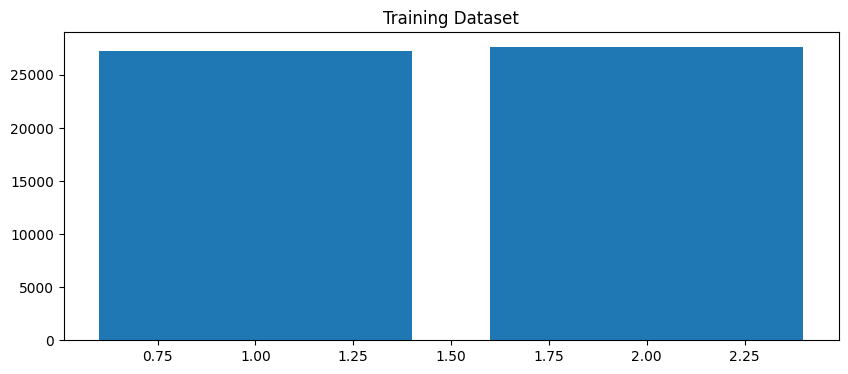

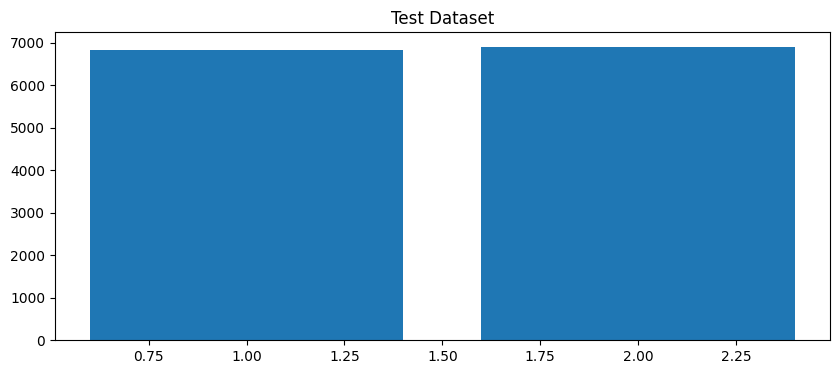

In [19]:
%matplotlib inline
plot_distribution(df_train,'label','Training Dataset')
plot_distribution(df_test,'label','Test Dataset')

In [20]:
pd.set_option("display.max_columns", None)

Verific daca cele 2 dataframe-uri au instante comune

In [21]:
print(pd.merge(df_train, df_test, how='inner', on=['text']))

Empty DataFrame
Columns: [index_x, text, label_x, index_y, label_y]
Index: []


# Data preparation

###TweetTokenizer for BERT like model

In [22]:
# https://huggingface.co/cardiffnlp/twitter-roberta-base

def preprocess(text):
    new_text = []
    if type(text)==float:
      print(text)
    for t in text.split(" "):
        t = '@USER' if t.startswith('@') and len(t) > 1 else t
        t = 'HTTPURL' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [23]:
print(
  preprocess(
      "SC has first two presumptive cases of coronavirus #COVIDIsEverywhere, DHEC confirms https://postandcourier.com/health/covid19/sc-has-first-two-presumptive-cases-of-coronavirus-dhec-confirms/article_bddfe4ae-5fd3-11ea-9ce4-5f495366cee6.html?utm_medium=social&utm_source=twitter&utm_campaign=user-share… via @postandcourier"
  )
)

SC has first two presumptive cases of coronavirus #COVIDIsEverywhere, DHEC confirms HTTPURL via @USER


In [24]:
df_train.dropna(subset=['text'], inplace=True)
df_test.dropna(subset=['text'], inplace=True)

In [25]:
df_train.head(1)

,index,text,label
8810,40088,As Donald Trump continues to sink his politica...,1


In [26]:
df_train.dropna(subset=['label'], inplace=True)
df_test.dropna(subset=['label'], inplace=True)

In [27]:
df_train['final'] = df_train['text'].apply(lambda x: preprocess(x))
df_test['final'] = df_test['text'].apply(lambda x: preprocess(x))

In [28]:
df_train[:1][['text','final']]

,text,final
8810,As Donald Trump continues to sink his politica...,As Donald Trump continues to sink his politica...


In [29]:
df_train.to_csv('/content/drive/MyDrive/dataset-misinformation/df_train_cleaned.csv')
df_test.to_csv('/content/drive/MyDrive/dataset-misinformation/df_test_cleaned.csv')

###BERT Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because:

(1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The encode_plus method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special [CLS] and [SEP] tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.

In [30]:
config.PRE_TRAINED_MODEL[0], config.PRE_TRAINED_MODEL[1], config.PRE_TRAINED_MODEL[2]

('kornosk/polibertweet-mlm',
 'cardiffnlp/twitter-roberta-base',
 'm-newhauser/distilbert-political-tweets')

In [31]:
bert_tokenizer = AutoTokenizer.from_pretrained(config.PRE_TRAINED_MODEL[2])

In [32]:
config.MAX_LEN[0]

128

In [33]:
def tokenize_function(text, tokenizer):
    tok = tokenizer(text,add_special_tokens=True, padding="max_length", max_length = config.MAX_LEN[0],truncation=True, return_tensors="pt")
    return tok['input_ids'], tok['attention_mask']

In [ ]:
df_train['input_ids'],df_train['attention_mask'] = zip(*df_train.apply(lambda x: tokenize_function(x['final'],bert_tokenizer), axis=1 ))

In [ ]:
df_test['input_ids'], df_test['attention_mask'] = zip(*df_test.apply(lambda x: tokenize_function(x['final'],bert_tokenizer), axis=1))

In [ ]:
df_train.sample(1)

,index,text,label,final,input_ids,attention_mask
28055,11414,Iran s Supreme Court has upheld a death senten...,2,Iran s Supreme Court has upheld a death senten...,"[[tensor(101), tensor(4238), tensor(1055), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


### Download BERT pre-trained model

In [ ]:
bert_model = AutoModel.from_pretrained(config.PRE_TRAINED_MODEL[2])

Some weights of the model checkpoint at m-newhauser/distilbert-political-tweets were not used when initializing DistilBertModel: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
config.PRE_TRAINED_MODEL[1]

'cardiffnlp/twitter-roberta-base'

### Create Dataset

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, df, encoded_y):
      self.df = df
      self.y = encoded_y

  def __len__(self):
      return len(self.df)

  def __getitem__(self, idx):
      item = self.df.iloc[idx]
      text = item['final']
      label = self.y[idx]

      return {
          'text': text,
          'input_ids' : torch.tensor(item['input_ids']).to(config.DEVICE),
          'attention_mask' : torch.tensor(item['attention_mask']).to(config.DEVICE),
          'labels' : torch.tensor(label).to(config.DEVICE)
      }

In [ ]:
df_train.head(1)

,index,text,label,final,input_ids,attention_mask
22264,29673,LONDON — Who knew that déjà vu could smell ...,2,LONDON — Who knew that déjà vu could smell ...,"[[tensor(101), tensor(2414), tensor(1517), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [ ]:
len(df_test)

13721

In [ ]:
config.DEVICE

device(type='cuda', index=0)

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_trian, df_val = train_test_split(df_train, test_size=0.1)
encoder = LabelEncoder()
y_train = encoder.fit_transform(df_train.label.to_list())
y_test = encoder.transform(df_test.label.to_list())
y_val = encoder.transform(df_val.label.to_list())

In [ ]:
train_set = CustomDataset(df_train, y_train)
test_set = CustomDataset(df_test, y_test)
val_set = CustomDataset(df_val, y_val)
print("Train:", len(train_set),"Test:", len(test_set),"Validation:", len(val_set))

Train: 54883 Test: 13721 Validation: 5489


In [ ]:
df_test.head(2)

,index,text,label,final,input_ids,attention_mask
63590,14848,China s agreement to begin talks with the Asso...,2,China s agreement to begin talks with the Asso...,"[[tensor(101), tensor(2859), tensor(1055), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
21427,61255,"GoldSwitzerland October 27, 2016 \nThere are a...",1,"GoldSwitzerland October 27, 2016 \nThere are a...","[[tensor(101), tensor(2751), tensor(26760), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [ ]:
print(len(test_set))
print(test_set[2])

13721


<ipython-input-38-e84654f0f2ef>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids' : torch.tensor(item['input_ids']).to(config.DEVICE),


{'text': 'A Connecticut teenager who tried to reject life-saving chemotherapy for\xa0Hodgkin’s lymphoma can be forced to undergo the treatment anyway, the state’s\xa0Supreme Court ruled Thursday.\n\nThe court unanimously affirmed a trial court judgment, which found that state officials could intervene and take over the care for the girl — identified as “Cassandra C.”\n\n“This court agrees with the trial court that, even assuming that the mature minor doctrine applies in this state, the respondents have failed to meet their burden of proving under any standard that Cassandra was a mature minor and capable of acting independently concerning her life threatening medical condition,” Thursday’s order reads.\n\nThe teen’s mother has said that her daughter “knows the long-term effects of having chemo” and doesn’t want to put “poison” in her body.\n\n“She may not be able to have children after this, because it affects everything in your body,” her mother, Jackie Fortin, said in a video posted 

<ipython-input-38-e84654f0f2ef>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask' : torch.tensor(item['attention_mask']).to(config.DEVICE),


### Create Dataloader

In [ ]:
config.BATCH_SIZE = 32

In [ ]:
len(test_set)

13721

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=config.BATCH_SIZE)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.BATCH_SIZE)

In [ ]:
data = next(iter(train_dataloader))
print(data.keys())
print(data['input_ids'].squeeze(1).shape)
print(data['labels'].shape)
print(data['attention_mask'].squeeze(1).shape)

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])


<ipython-input-38-e84654f0f2ef>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids' : torch.tensor(item['input_ids']).to(config.DEVICE),
<ipython-input-38-e84654f0f2ef>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask' : torch.tensor(item['attention_mask']).to(config.DEVICE),


# Classifier

In [ ]:
class TweetClassifier(nn.Module):
    def __init__(self, bertModel, out_feat, freeze_bert):
        super().__init__()
        D_in, H, D_out = bertModel.config.hidden_size, 50, out_feat
        self.bert = bertModel
        self.classifier = nn.Sequential(
            nn.Linear(D_in,H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )
        # Freeze the pre-trained layers of BERT model
        if freeze_bert==True:
          for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask )
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits

# Evaluate

In [ ]:
def evaluate(model, val_dataloader, loss_fn, device):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        mask = batch['attention_mask'].squeeze(1).to(device)
        input_id = batch['input_ids'].squeeze(1).to(device)
        targets = batch["labels"].to(device)

        with torch.no_grad():
            logits = model(input_id, mask)

        loss = loss_fn(logits, targets)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        batch_acc = (preds == targets).cpu().numpy().mean() 
        val_accuracy.append(batch_acc)
    
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

# Train

In [ ]:
def train(model, train_dataloader, val_dataloader, model_path, epochs):
  print(f"Start training...\n")

  min_epoch_loss = np.Inf
  log_info = {"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}
  trigger_times = 0
  patience = 4
  best_model = model

  for epoch in range(epochs):
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Acc':^12}| {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*70)

    # Measure the elapsed time of each epoch
    t0_epoch, t0_batch = time.time(), time.time()

    # Tracking variables
    batch_loss, batch_counts = 0, 0  # updated from 20 to 20 batches
    epoch_loss = []
    epoch_accuracy = []

    # Put the model into the training mode
    model.train()

    for step, batch in enumerate(train_dataloader):
      batch_counts +=1

      model.zero_grad() 
      
      mask = batch['attention_mask'].squeeze(1).to(config.DEVICE)
      input_id = batch['input_ids'].squeeze(1).to(config.DEVICE)
      targets = batch["labels"].type(torch.LongTensor)
      targets = targets.to(config.DEVICE)

      logits =  model(input_id, mask)
      
      loss = loss_fn(logits, targets)
      batch_loss += loss.item()
      epoch_loss.append(loss.item())

      preds = torch.argmax(logits,dim=1).flatten()

      batch_acc = (preds==targets).cpu().numpy().mean()
      epoch_accuracy.append(batch_acc)

      loss.backward()
      optimizer.step()
      
      # Print the loss values and time elapsed for every 20 batches
      if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
          time_elapsed = time.time() - t0_batch

          print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {batch_acc:^12.6f} |{'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
          
          batch_loss, batch_counts = 0, 0
          t0_batch = time.time()

    epoch_loss = np.mean(epoch_loss)
    epoch_accuracy = np.mean(epoch_accuracy)


    val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn, config.DEVICE)
    time_elapsed = time.time() - t0_epoch

    print("-"*70)
    print(f"{epoch + 1:^7} | {'-':^7} | {epoch_loss:^12.6f} |{epoch_accuracy:^12.6f}| {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
    log_info['train_loss'].append((epoch, epoch_loss))
    log_info['train_acc'].append((epoch, epoch_accuracy))
    log_info['val_loss'].append((epoch, val_loss))
    log_info['val_acc'].append((epoch, val_accuracy))
    print("-"*70)
    
    if val_loss < min_epoch_loss:
      min_epoch_loss = val_loss
      trigger_times = 0 
      print('Trigger times: 0')
      print(f"Saving model with val loss: {val_loss} and validation accuracy: {val_accuracy}")
      torch.save(model, model_path)
      best_model = model
    else:
      trigger_times += 1
      print('Trigger Times:', trigger_times)
    if trigger_times > patience:
        print('Early stopping!\nStart to test process.')
        return best_model, log_info

  print(f"Training Complete")
  return best_model, log_info

# Start training

In [ ]:
config.DEVICE

device(type='cuda', index=0)

In [ ]:
model = TweetClassifier(bert_model, 2, True).to(config.DEVICE)

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(config.DEVICE)

optimizer = AdamW(model.parameters(),lr=config.LEARNING_RATE[0], 
                  eps=config.EPS, correct_bias=False, no_deprecation_warning=True)

best_model, log_info = train(model, train_dataloader, val_dataloader, config.MODEL_PATH, config.EPOCHS)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


<ipython-input-39-e84654f0f2ef>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids' : torch.tensor(item['input_ids']).to(config.DEVICE),
<ipython-input-39-e84654f0f2ef>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask' : torch.tensor(item['attention_mask']).to(config.DEVICE),


   1    |   20    |   0.697198   |   0.625000   |    -      |     -     |  167.55  
   1    |   40    |   0.678911   |   0.437500   |    -      |     -     |  157.09  
   1    |   60    |   0.692501   |   0.531250   |    -      |     -     |  169.05  
   1    |   80    |   0.689333   |   0.562500   |    -      |     -     |  158.59  
   1    |   100   |   0.686710   |   0.593750   |    -      |     -     |  164.68  
   1    |   120   |   0.683064   |   0.437500   |    -      |     -     |  159.17  
   1    |   140   |   0.679731   |   0.625000   |    -      |     -     |  166.82  
   1    |   160   |   0.679221   |   0.781250   |    -      |     -     |  161.43  
   1    |   180   |   0.678673   |   0.593750   |    -      |     -     |  160.83  
   1    |   200   |   0.683699   |   0.593750   |    -      |     -     |  164.40  
   1    |   220   |   0.672375   |   0.437500   |    -      |     -     |  161.25  
   1    |   240   |   0.676700   |   0.375000   |    -      |     -     |  1

# Check model's performance during training

In [ ]:
log_info  

{'train_loss': [(0, 0.6511192219483825),
  (1, 0.5995305255402774),
  (2, 0.5693367411206652),
  (3, 0.5499960793169228),
  (4, 0.5364986379177142),
  (5, 0.5274507527202715),
  (6, 0.5193524609704118),
  (7, 0.5117854553954306),
  (8, 0.5065576780960832),
  (9, 0.5014767955059494),
  (10, 0.4967534017938),
  (11, 0.4959683224801973),
  (12, 0.49042929677696495),
  (13, 0.4878217301880702),
  (14, 0.48597095595859424),
  (15, 0.48224226374934603),
  (16, 0.4784993168947858),
  (17, 0.4784402298482704),
  (18, 0.47471446363311826),
  (19, 0.4738517106187232)],
 'train_acc': [(0, 0.6395323426573427),
  (1, 0.704551524864025),
  (2, 0.7218033702408702),
  (3, 0.7332277097902098),
  (4, 0.7394012237762237),
  (5, 0.7434440559440559),
  (6, 0.7481849747474748),
  (7, 0.7533629564879565),
  (8, 0.7561370920745921),
  (9, 0.7570901320901321),
  (10, 0.7616914335664335),
  (11, 0.7614243395493396),
  (12, 0.7636278651903652),
  (13, 0.7651454448329448),
  (14, 0.7669361888111889),
  (15, 0.769

In [ ]:
def Convert(tup, di):
  di={"epoch":[],"val":[]}
  for a, b in tup:
    di['epoch'].append(a)
    di['val'].append(b)
  return di

def plot_performance(log_info):
  dict_train={}
  dict_val={}

  dict_train = Convert(log_info['train_acc'], dict_train)
  dict_val = Convert(log_info['val_acc'], dict_val)

  dict_train_loss={}
  dict_val_loss={}

  dict_train_loss = Convert(log_info['train_loss'], dict_train_loss)
  dict_val_loss = Convert(log_info['val_loss'], dict_val_loss)

  fig = plt.figure()
  plt.plot(dict_train['epoch'], dict_train['val'] , 'bo', label = 'Training Accuracy')
  plt.plot(dict_val['epoch'], dict_val['val'], 'b', label = 'Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.show()


  fig = plt.figure()
  plt.plot(dict_train_loss['epoch'], dict_train_loss['val'] , 'bo', label = 'Training Loss')
  plt.plot(dict_val_loss['epoch'], dict_val_loss['val'], 'b', label = 'Validation Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

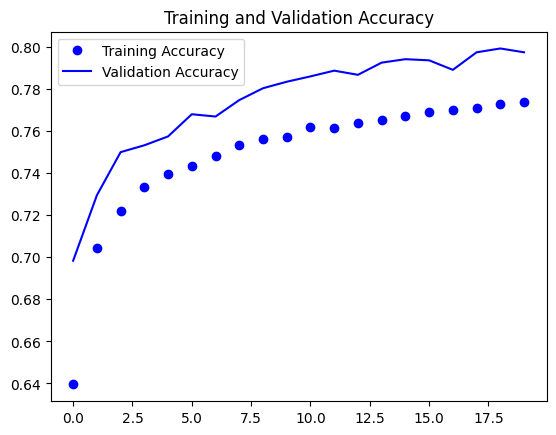

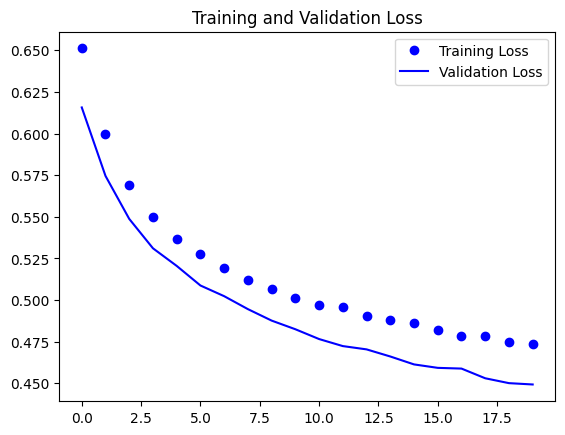

In [ ]:
plot_performance(log_info)

# Evaluate on test data

In [ ]:
loaded_model = torch.load(config.MODEL_PATH)
test_loss, test_accuracy = evaluate(loaded_model, test_dataloader,loss_fn, config.DEVICE)

<ipython-input-38-e84654f0f2ef>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids' : torch.tensor(item['input_ids']).to(config.DEVICE),
<ipython-input-38-e84654f0f2ef>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask' : torch.tensor(item['attention_mask']).to(config.DEVICE),


In [ ]:
print("Model ",config.MODEL_PATH,":\nLOSS =",test_loss,"\nACCURACY =",test_accuracy)

Model  /content/drive/MyDrive/model_misinf_v3.pt :
LOSS = 0.45668679420208874 
ACCURACY = 0.7892540792540793


# Get predictions

In [ ]:
def get_targets_and_predictios_as_tensors(dataloader,model):
  predictions = []
  targets = []
  for batch in dataloader:
    input_ids = batch['input_ids']
    masks = batch['attention_mask']
    batch_targets = batch['labels']

    with torch.no_grad():
      batch_predictions = model(input_ids.squeeze(1),masks.squeeze(1))
      batch_predictions = torch.argmax(batch_predictions, dim=1).flatten()
      predictions.append(batch_predictions.cpu())
      targets.append(batch_targets.cpu())


  final_predictions = np.concatenate(predictions)
  final_targets = np.concatenate(targets)

  return final_targets, final_predictions

In [ ]:
final_targets, final_predictions = get_targets_and_predictios_as_tensors(test_dataloader, loaded_model)

correct_classifications = sum(final_targets==final_predictions)
misclassified = len(final_predictions) - correct_classifications

print("TEST DATASET:  number of samples misclassified: ", str(misclassified),"/",str(len(final_predictions)))
print("TEST DATASET:  number of samples correct classified: ", correct_classifications,"/",str(len(final_predictions)))

<ipython-input-38-e84654f0f2ef>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids' : torch.tensor(item['input_ids']).to(config.DEVICE),
<ipython-input-38-e84654f0f2ef>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask' : torch.tensor(item['attention_mask']).to(config.DEVICE),


TEST DATASET:  number of samples misclassified:  2892 / 13721
TEST DATASET:  number of samples correct classified:  10829 / 13721


In [ ]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


print ('\n*Classification Report for Test Data:\n', classification_report(final_targets, final_predictions))

cm = confusion_matrix(final_targets, final_predictions, normalize='true')



*Classification Report for Test Data:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78      6798
           1       0.78      0.81      0.79      6923

    accuracy                           0.79     13721
   macro avg       0.79      0.79      0.79     13721
weighted avg       0.79      0.79      0.79     13721

